In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import gym
from gym import spaces
import random
from itertools import product

import importlib
from util.clean_data import *
import util.plot
importlib.reload(util.plot)
from util.plot import plot_rewards
from PaperEmbedding import PaperEmbeddingModule
from UserModel import UserModel
from GreedyDQNAgent import GreedyDQNAgent
from PaperDiscoveryEnv import PaperDiscoveryEnv

In [2]:
full_df = pd.read_csv("../data/scientometrics-and-bibliometrics-research.csv", low_memory=False)
df = select_relevant_features(full_df)
df['topics.display_name'] = df['topics.display_name'].apply(lambda x: pad_topic_list(x, max_len=3, pad_token="<PAD>"))
df['topics.score'] = df['topics.score'].apply(lambda x: pad_topic_list(x, max_len=3, pad_token=0.0))
df = normalize_numerical_features(df)

In [3]:
df

,title,publication_year,cited_by_count,topics.display_name,topics.score,publication_year_norm,cited_by_count_norm
0,How to conduct a bibliometric analysis: An ove...,2021,6635,"[scientometrics and bibliometrics research, <P...","[0.9736, 0.0, 0.0]",0.996341,1.000000
1,Analyzing the past to prepare for the future: ...,2002,6002,"[scientometrics and bibliometrics research, De...","[0.8112, 0.8084, 0.7988]",0.978037,0.987637
2,Co‐citation in the scientific literature: A ne...,1973,4591,"[scientometrics and bibliometrics research, <P...","[0.9994, 0.0, 0.0]",0.946613,0.954593
3,"Comparison of PubMed, Scopus, Web of Science, ...",2007,3769,"[scientometrics and bibliometrics research, Bi...","[0.9943, 0.9924, 0.9793]",0.983010,0.930270
4,The journal coverage of Web of Science and Sco...,2015,3167,"[scientometrics and bibliometrics research, Ac...","[0.9994, 0.9448, 0.9224]",0.990731,0.908817
...,...,...,...,...,...,...,...
50195,Issue Publication Information,2018,0,"[scientometrics and bibliometrics research, <P...","[0.5676, 0.0, 0.0]",0.993555,0.000000
50196,W. A. TAYLOR and CO.,1961,0,"[scientometrics and bibliometrics research, Ir...","[0.8668, 0.8155, 0.7664]",0.932099,0.000000
50197,VARIAN associates,1962,0,"[scientometrics and bibliometrics research, In...","[0.2804, 0.2517, 0.0]",0.933348,0.000000
50198,scientific products,1963,0,"[scientometrics and bibliometrics research, <P...","[0.315, 0.0, 0.0]",0.934589,0.000000


Interaction length = 10

In [776]:
hyperparameters = {
    'lr': [0.001, 0.0005],
    'eps_decay': [250],
    'batch_size': [128],
    'n_neurons': [128, 256],
    'gamma': [0.7, 0.8]
}
num_episodes = 8000

best_dqn_reward = [float('-inf')]
best_dqn_params = None
dqn_rewards = []
dqn_hyperparameter_labels = []

for lr, eps_decay, batch_size, n_neurons, gamma in product(
    hyperparameters['lr'],
    hyperparameters['eps_decay'],
    hyperparameters['batch_size'],
    hyperparameters['n_neurons'],
    hyperparameters['gamma']):

    try:
        env = PaperDiscoveryEnv(df, satisfied_at=10)
        agent = GreedyDQNAgent(env, lr=lr, eps_decay=eps_decay, batch_size=batch_size, n_neurons=n_neurons, gamma=gamma)
        rewards = agent.train(num_episodes=num_episodes)
        dqn_rewards.append(rewards)
        sum_dqn_rewards = sum(rewards)

        print(f"{(lr, eps_decay, batch_size, n_neurons, gamma)} - avg. reward = {sum_dqn_rewards / num_episodes}")
        dqn_hyperparameter_labels.append(f"lr={lr}, eps_decay={eps_decay}, batch_size={batch_size}, n_neurons={n_neurons}, gamma={gamma}")


        if sum_dqn_rewards > sum(best_dqn_reward):
            best_dqn_reward = rewards
            best_dqn_params = {'lr': lr, 'eps_decay': eps_decay, 'batch_size': batch_size, 'n_neurons': n_neurons, 'gamma': gamma}
            torch.save(agent.policy_net.state_dict(), "model_weights/best_dqn.pth")
    except Exception as e:
        continue

print(f"Best hyperparameters: {best_dqn_params} with average reward: {sum(best_dqn_reward)}")

/var/folders/7y/58r1nbq91psb3zbw1k0f7bzc0000gn/T/ipykernel_26536/3813415055.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
/var/folders/7y/58r1nbq91psb3zbw1k0f7bzc0000gn/T/ipykernel_26536/3813415055.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


(0.001, 250, 128, 128, 0.7) - avg. reward = 15.89475
(0.001, 250, 128, 128, 0.8) - avg. reward = 15.38125
(0.001, 250, 128, 256, 0.7) - avg. reward = 15.6695
(0.001, 250, 128, 256, 0.8) - avg. reward = 15.3485
(0.0005, 250, 128, 128, 0.7) - avg. reward = 15.558
(0.0005, 250, 128, 128, 0.8) - avg. reward = 14.98
(0.0005, 250, 128, 256, 0.7) - avg. reward = 15.706
(0.0005, 250, 128, 256, 0.8) - avg. reward = 15.4935
Best hyperparameters: {'lr': 0.001, 'eps_decay': 250, 'batch_size': 128, 'n_neurons': 128, 'gamma': 0.7} with average reward: [-18, -8, -10, -6, -8, -16, -8, -4, -26, -10, 4, -2, -10, -10, -14, -6, 0, -8, -6, -6, -12, -8, 4, -4, -6, -8, -6, -8, -8, -20, -14, -6, -6, -8, -4, -4, -12, -8, -20, -2, -18, -6, -14, -20, -2, -30, -16, -10, -18, -16, -18, -16, 0, -4, -4, -16, -18, -2, -28, -10, -18, -8, -8, -16, -10, -10, -6, 0, 2, 0, 0, -2, -8, -6, 0, -8, -10, 0, 2, -4, 0, 4, 0, -10, -4, 0, 0, -4, 4, 0, -10, -10, -6, -6, -6, -16, 0, 2, 0, 2, 4, -2, 2, -4, -4, 0, 0, -8, 6, -10, -2, -

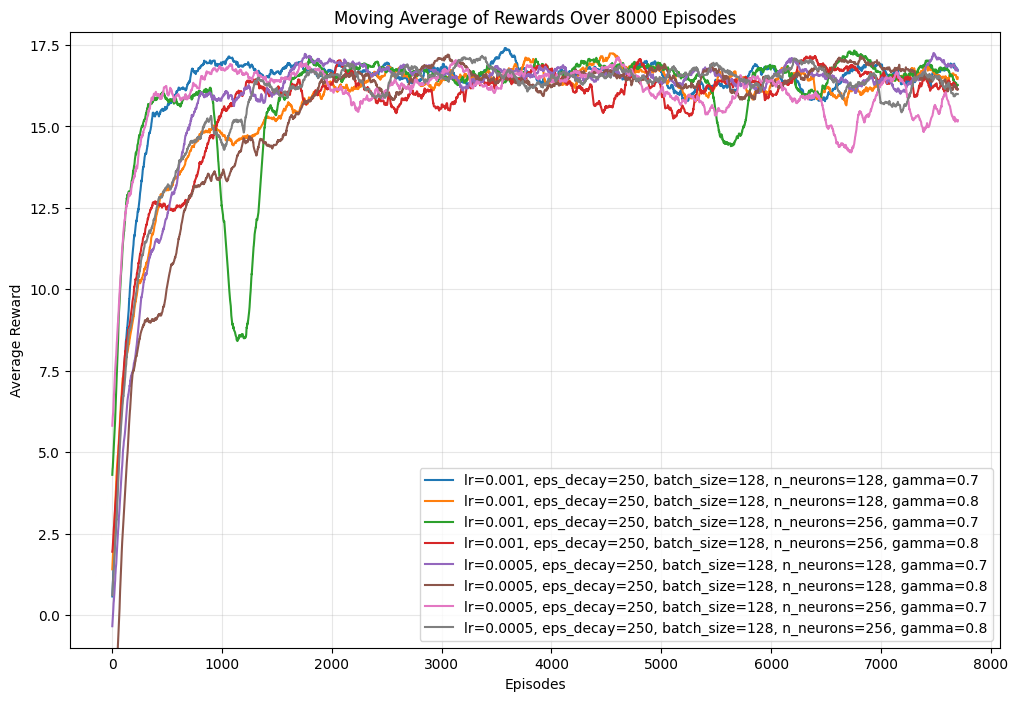

In [832]:
plot_rewards(rewards=dqn_rewards, labels=dqn_hyperparameter_labels, num_episodes=8000)

Interaction length = 20

In [8]:
satisfied_at_n = [10, 20, 30, 50, 100]
num_episodes = 10000

interaction_rewards = []

for satisfied_at in satisfied_at_n:
    env = PaperDiscoveryEnv(df, satisfied_at=satisfied_at)
    agent = GreedyDQNAgent(env, lr=0.001, eps_decay=250, batch_size=128, n_neurons=128, gamma=0.7)
    agent.policy_net.load_state_dict(torch.load("model_weights/best_dqn.pth"))
    agent.policy_net.eval()
    rewards = agent.train(num_episodes=num_episodes)
    interaction_rewards.append(rewards)
    print(f"satisfied_at = {satisfied_at} - COMPLETE")

/Users/monika/fair-bibliography-discovery-reinforcement-learning/src/GreedyDQNAgent.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
/Users/monika/fair-bibliography-discovery-reinforcement-learning/src/GreedyDQNAgent.py:130: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)


satisfied_at = 10 - COMPLETE
satisfied_at = 20 - COMPLETE


KeyboardInterrupt: 